In [61]:
import numpy as np
import os
import shutil
import pandas as pd
import sys
import gzip
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats
import copy
import re

## Import Files

In [62]:
path = '/Users/nanatang/VAserversim/m/Researchers/SerenaT/fromjapan_fullruns/'

In [106]:
reportfile = 'grand_PVS_report_022124.csv'
report = pd.read_csv(os.path.join(path,reportfile))

# reportrawfile = 'grand_PVS_report_RAW.csv'
# reportraw = pd.read_csv(os.path.join(path,reportrawfile))

demofile = 'idaSearch_2_21_2024-ADNI3.csv'
demo = pd.read_csv(os.path.join(path,demofile))

dxfile = 'dx_adni3.csv'
dx = pd.read_csv(os.path.join(path,dxfile))

## Harmonizing the datasets


Step 1: harmonize by making all the files have the same columns (at least: subject codes (just the number), Scan code (subject codes and the year),
        visit code, and image code)

In [107]:
dx_clean = pd.DataFrame({'SubjectCodes':dx['PTID'],'Diagnosis':dx['DIAGNOSIS']})
dx_clean = dx_clean.groupby('SubjectCodes').agg({'Diagnosis':'first'})
dx_clean.reset_index(inplace=True)
dx_clean.drop_duplicates('SubjectCodes',inplace=True)
dx_clean.dropna(inplace=True)
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].apply(str)
replacements = {'1.0':'CN','2.0': 'MCI', '3.0': 'AD'}
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].map(replacements).fillna(dx_clean['Diagnosis'])

dx_clean

,SubjectCodes,Diagnosis
0,002_S_0413,CN
1,002_S_1155,MCI
2,002_S_1261,MCI
3,002_S_1280,CN
4,002_S_4213,CN
...,...,...
1354,941_S_7074,CN
1355,941_S_7085,MCI
1356,941_S_7087,CN
1357,941_S_7091,CN


In [108]:
# subjcodes = []
# for subj in reportraw['subjects'].array:
#     pattern = re.compile('\d{3}_\w_\d{4}')
#     subjcodes.append(re.search(pattern,subj)[0])
# imagecodes = []
# for image in reportraw['subjects'].array:
#     pattern = re.compile('i\d*')
#     imagecodes.append(re.search(pattern,image)[0])
# visitcodes = []
# for visit in reportraw['subjects'].array:
#     pattern = re.compile('y\d{2}')
#     visitcodes.append(re.search(pattern,visit)[0])
# reportraw.insert(2,'SubjectCodes',subjcodes)
# reportraw.insert(3,'ImageCodes',imagecodes)
# reportraw.insert(4,'VisitCodes',visitcodes)

# scancodes = 'ADNI3_' + reportraw['SubjectCodes'] + reportraw['VisitCodes']
# reportraw.insert(2,'ScanCode',scancodes)
# #reportraw

In [109]:
subjcodes = []
for subj in report['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in report['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in report['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
report.insert(2,'SubjectCodes',subjcodes)
report.insert(3,'ImageCodes',imagecodes)
report.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + report['SubjectCodes'] + report['VisitCodes']
report.insert(2,'ScanCode',scancodes)
#report

## Data cleaning
Includes:
- Attaching demographics info (Age, Sex, Weight) to PVS report with 'demofile'
- Fill in correct research group for subjects in the PVS report with 'dxadni3_file'
- Figure out what years are missing for each subject that exists in the PVS report & why
- Function to clean out those that don't have WMH (optional)
- Remove outliers (optional, defined at 3std away from mean)

Step 1: attach demographics with LONI demographics file

In [110]:
# Convert Visit Code to visit number to match report
demo_clean = demo.replace(to_replace=r'ADNI3 Initial Visit-Cont Pt', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI Screening', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 1 Visit', value='y01', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 2 Visit', value='y02', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 3 Visit', value='y03', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 4 Visit', value='y04', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 5 Visit', value='y05', regex=True)
demo_clean['Phase'] = demo_clean['Phase'].replace(to_replace=r'ADNI 3', value='ADNI3', regex=True)

# add year, phase, visit and Image ID to subject ID
subjectfullid = demo_clean['Phase']+ '_' + demo_clean['Subject ID'] + demo_clean['Visit'] + '_i' + demo_clean['Image ID'].apply(str)
demo_clean.insert(1,'subjects',subjectfullid)
demo_clean = demo_clean.rename(columns={'Subject ID': 'SubjectCodes'})
#demo_clean
#demo_clean['Subject ID'][demo_clean['Subject ID'] == 'ADNI3_003_S_1122y01_i909791']

In [111]:
demo_clean.to_csv(os.path.join(path,'demographics_report.csv'), index=False)

In [112]:
# add age, weight, sex columns
# RUNNING THIS CELL MORE THAN ONCE WILL PRODUCE ISSUES

demoonly_clean = pd.DataFrame({'subjects':demo_clean['subjects'],'Age':demo_clean['Age'],'Weight':demo_clean['Weight'],'Sex':demo_clean['Sex']})
#report
reporttemp = copy.deepcopy(report)
reporttemp = reporttemp.merge(demoonly_clean,how='left',on='subjects')
reporttemp.drop_duplicates(inplace=True)
reporttemp = reporttemp.reset_index(drop=True)


In [113]:
#reporttemp = reporttemp.iloc[:,[0,1,2,3,4,5,14,15,16,6,7,8,9,10,11,12,13]]
reporttemp

,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,Age,Weight,Sex
0,ADNI3_114_S_2392y00_i909791,EMCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,70.6,65.8,F
1,ADNI3_114_S_4404y00_i949873,EMCI,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,88.6,79.4,F
2,ADNI3_128_S_4742y00_i1039209,EMCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,76.8,49.9,F
3,ADNI3_027_S_4919y04_i1398602,EMCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,83.2,83.3,F
4,ADNI3_067_S_2304y02_i1215232,EMCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,69.8,81.6,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,70.9,80.3,M
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,69.7,100.2,F
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,63.7,72.6,M
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,66.9,84.4,M


In [114]:
# fix the NaN values
# some of these subjects have the wrong image ID or the wrong year labeled
# keeping the report labels because they presumably match the logs in the VA

nullind = reporttemp[reporttemp['Sex'].isnull()].index
#print(nullind)
# reporttemp = reporttemp.dropna(axis=0)
# reporttemp

sex = pd.Series(['M','M','F','F','F'])
age = pd.Series([74.1,86.8,60.2,88.7,75.8])
weight = pd.Series([96.9,73,72.6,55.3,81])
visit = pd.Series(['y01','y01','y02','y01','y01'])

sex_all = reporttemp['Sex']
sex_all[nullind] = sex
reporttemp['Sex'] = sex_all

age_all = reporttemp['Age']
age_all[nullind] = age
reporttemp['Age'] = age_all

weight_all = reporttemp['Weight']
weight_all[nullind] = weight
reporttemp['Weight'] = weight_all

#print(reporttemp.loc[nullind,:])


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_3231/3943587511.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_all[nullind] = sex
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_3231/3943587511.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_all[nullind] = age
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_3231/3943587511.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_al

Step 2: Fix research group

In [115]:
reporttemptemp = copy.deepcopy(reporttemp)
dx_cleantemp = copy.deepcopy(dx_clean)

In [116]:
mcifixmerge = reporttemptemp.merge(dx_clean,how='left',on='SubjectCodes')
mcifixmerge.drop_duplicates(inplace=True)

In [117]:
nulls = mcifixmerge[mcifixmerge['Diagnosis'].isnull()].index
rg_all = mcifixmerge['Diagnosis']
rg_all[nulls]=mcifixmerge['research group'][nulls].values
mcifixmerge['Diagnosis'] = rg_all
#mcifixmerge

/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_3231/2974683064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rg_all[nulls]=mcifixmerge['research group'][nulls].values


In [118]:
# switch the labels so research group = Diagosis
mcifixmerge['research group'] = mcifixmerge['Diagnosis']
mcifixmerge = mcifixmerge.drop('Diagnosis',axis=1)

In [119]:
# rename report variable
report_clean = copy.deepcopy(mcifixmerge)

In [120]:
# just for ref: number of subjects
report_clean.groupby('SubjectCodes').any()

,subjects,research group,ScanCode,ImageCodes,VisitCodes,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,Age,Weight,Sex
SubjectCodes,,,,,,,,,,,,,,,,
002_S_0413,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1155,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1261,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1280,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_4213,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941_S_7051,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
941_S_7074,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
941_S_7085,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [121]:
# optional other cleaning:
# anything that doesn't have WMH mask

nowmh = report_clean[report_clean['WMH mask'] == 'no'].index
report_clean.drop(nowmh,inplace=True)
display(report_clean)

# remove outliers in each group 3 std deviations on both sides)
# group by disease stage
# grouped = report_clean.groupby(['research group'])
# ad = grouped.get_group('AD')
# mci = grouped.get_group('MCI')
# cn = grouped.get_group('CN')

# cnoutlier = cn[(np.abs(stats.zscore(cn['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(cn['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(cn['icv norm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(cn['icv norm wm'])) > 3)].index
# cn.drop(cnoutlier,inplace=True)

# mcioutlier = mci[(np.abs(stats.zscore(mci['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(mci['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(mci['icv norm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(mci['icv norm wm'])) > 3)].index
# mci.drop(mcioutlier,inplace=True)

# adoutlier = ad[(np.abs(stats.zscore(ad['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(ad['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(ad['icv norm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(ad['icv norm wm'])) > 3)].index
# ad.drop(adoutlier,inplace=True)


,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,Age,Weight,Sex
0,ADNI3_114_S_2392y00_i909791,MCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,70.6,65.8,F
1,ADNI3_114_S_4404y00_i949873,AD,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,88.6,79.4,F
2,ADNI3_128_S_4742y00_i1039209,MCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,76.8,49.9,F
3,ADNI3_027_S_4919y04_i1398602,MCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,83.2,83.3,F
4,ADNI3_067_S_2304y02_i1215232,MCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,69.8,81.6,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,70.9,80.3,M
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,69.7,100.2,F
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,63.7,72.6,M
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,66.9,84.4,M


In [122]:
# get visit year out
visityear = []
for visit in report_clean['VisitCodes'].array:
    pattern = re.compile('\d{2}')
    visityear.append(int(re.search(pattern,visit)[0]))

report_clean['VisitYear'] = visityear
report_clean

,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,Age,Weight,Sex,VisitYear
0,ADNI3_114_S_2392y00_i909791,MCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,70.6,65.8,F,0
1,ADNI3_114_S_4404y00_i949873,AD,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,88.6,79.4,F,0
2,ADNI3_128_S_4742y00_i1039209,MCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,76.8,49.9,F,0
3,ADNI3_027_S_4919y04_i1398602,MCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,83.2,83.3,F,4
4,ADNI3_067_S_2304y02_i1215232,MCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,69.8,81.6,M,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,70.9,80.3,M,0
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,69.7,100.2,F,0
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,63.7,72.6,M,0
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,66.9,84.4,M,0


## Extract Stats -- Cross Sectional

In [125]:
# # step 1: make a new dataframe with averaged PVS values across years for each subjects (so each subject has 1 data point),
# #         then group by research group
# # assumes that each subject stays in their repsective research groups

# the size of cs report is the number of subjects that exist
cs_report = report_clean.groupby('SubjectCodes',as_index=False).agg({'research group':'first','Age': 'mean', 'Sex': 'first', 'Weight': 'mean', 'VisitYear': 'max', \
                                                                 'pvscount': 'mean', 'pvsvol': 'mean', 'icv norm': 'mean', \
                                                               'pvscountwm': 'mean','pvsvolwm': 'mean','icv norm wm': 'mean', \
                                                                #'wmVOL':'mean','wmVOLnorm':'mean','gmVOL':'mean','gmVOLnorm':'mean','wmhVOL':'mean','wmhVOLnorm':'mean','icv':'mean'
                                                                })
# regroup into research groups
cs_grouped = cs_report.groupby(['research group'])
ad_cs = cs_grouped.get_group('AD')
mci_cs = cs_grouped.get_group('MCI')
cn_cs = cs_grouped.get_group('CN')

# no conversions; used merge to check for any conversions


In [22]:
# cs_report.to_csv(os.path.join(path,'cross_sectional_report.csv'))

In [127]:
# step 2: extract global stats in each group (mean, std)
## this is done before the transform

col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean PVS count', 'std PVS count', 'mean PVS volume', 'std PVS volume', 'mean PVS volume normed', 'std PVS volume normed']

subjcounts = [str(cn_cs.count()[0]),str(mci_cs.count()[0]),str(ad_cs.count()[0])]

mean_PVS_count = [cn_cs['pvscount'].mean(), mci_cs['pvscount'].mean(), ad_cs['pvscount'].mean()]
std_PVS_count = [cn_cs['pvscount'].std(), mci_cs['pvscount'].std(), ad_cs['pvscount'].std()]

mean_PVS_vol = [cn_cs['pvsvol'].mean(), mci_cs['pvsvol'].mean(), ad_cs['pvsvol'].mean()]
std_PVS_vol = [cn_cs['pvsvol'].std(), mci_cs['pvsvol'].std(), ad_cs['pvsvol'].std()]

mean_PVS_icvnorm = [cn_cs['icv norm'].mean(), mci_cs['icv norm'].mean(), ad_cs['icv norm'].mean()]
std_PVS_icvnorm = [cn_cs['icv norm'].std(), mci_cs['icv norm'].std(), ad_cs['icv norm'].std()]

statsall = pd.DataFrame([subjcounts,mean_PVS_count,std_PVS_count,mean_PVS_vol,std_PVS_vol,mean_PVS_icvnorm,std_PVS_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Stats PVS All')

# mean_PVS_countwm = [cn_cs['pvscountwm'].mean(), mci_cs['pvscountwm'].mean(), ad_cs['pvscountwm'].mean()]
# std_PVS_countwm = [cn_cs['pvscountwm'].std(), mci_cs['pvscountwm'].std(), ad_cs['pvscountwm'].std()]

# mean_PVS_volwm = [cn_cs['pvsvolwm'].mean(), mci_cs['pvsvolwm'].mean(), ad_cs['pvsvolwm'].mean()]
# std_PVS_volwm = [cn_cs['pvsvolwm'].std(), mci_cs['pvsvolwm'].std(), ad_cs['pvsvolwm'].std()]

# mean_PVS_icvnormwm = [cn_cs['icv norm wm'].mean(), mci_cs['icv norm wm'].mean(), ad_cs['icv norm wm'].mean()]
# std_PVS_icvnormwm = [cn_cs['icv norm wm'].std(), mci_cs['icv norm wm'].std(), ad_cs['icv norm wm'].std()]

# statswm = pd.DataFrame([subjcounts,mean_PVS_countwm,std_PVS_countwm,mean_PVS_volwm,std_PVS_volwm,mean_PVS_icvnormwm,std_PVS_icvnormwm],index=index,columns=col)
# statswm = statswm.style.set_caption('Stats PVS WM')

statsall

,CN,MCI,AD
# of subjects,547,318,104
mean PVS count,1548.235101,1650.591143,1816.455929
std PVS count,798.118913,907.036227,1092.625774
mean PVS volume,6554.000762,7016.943920,7592.690701
std PVS volume,2760.092269,3413.915324,3665.885061
mean PVS volume normed,0.004536,0.004732,0.005172
std PVS volume normed,0.001917,0.002271,0.002410


In [129]:
# step 3: same number subject correction

# # same number
# cn_num = cn[0:100]
# mci_num = mci[0:100]
# ad_num = ad

# # else keep the same
cn_num = cn_cs
mci_num = mci_cs
ad_num = ad_cs

In [130]:
# step 4: since the data is not normally distributed (right skewed), we need to log transform it

# playing around with choices: pvscount	pvsvol icv norm	pvscountwm pvsvolwm	icv norm wm

# # transform for most skewed
# cn_txfm = np.log(cn_num['icvnorm'])
# mci_txfm = np.log(mci_num['icvnorm'])
# ad_txfm = np.log(ad_num['icvnorm'])

# # transform for medium skewed
# cn_txfm = np.sqrt(cn_num['pvscount'])
# mci_txfm = np.sqrt(mci_num['pvscount'])
# ad_txfm = np.sqrt(ad_num['pvscount'])

# # no transform
cn_txfm = cn_num['icv norm']
mci_txfm = mci_num['icv norm']
ad_txfm = ad_num['icv norm']

# step 4.5: check that the tranform actually makes it normal - shapiro-wilks test?
## seems like I can't actually get it to be normal

print(stats.shapiro(cn_txfm))
print(stats.shapiro(mci_txfm))
print(stats.shapiro(ad_txfm))

ShapiroResult(statistic=0.9334383606910706, pvalue=6.891414319081836e-15)
ShapiroResult(statistic=0.9641011953353882, pvalue=4.538467521797429e-07)
ShapiroResult(statistic=0.9699935913085938, pvalue=0.018319422379136086)


In [131]:
# step 5: Stats (X^2, ANOVA, Ttest, Kruskal-Wallis, Mann-Whitney U)

# ANOVA?
fvalue, apvalue = stats.f_oneway(cn_txfm, mci_txfm, ad_txfm)
print('ANOVA: ' + str(fvalue) + ', ' + str(apvalue))

#ttest?
tvalue, tpvalue = stats.ttest_ind(cn_txfm,ad_txfm)
print('T-test: ' + str(tvalue) + ', ' + str(tpvalue))

#Kruskal?
kvalue, kpvalue = stats.kruskal(cn_txfm, mci_txfm, ad_txfm)
print('Kruskal Wallis: ' + str(kvalue) + ', ' + str(kpvalue))

#MannWhitney?
mvalue, mpvalue = stats.mannwhitneyu(cn_txfm,ad_txfm)
print('Mann-Whitney U: ' + str(mvalue) + ', ' + str(mpvalue))

# bootstrap?



ANOVA: 4.248311164270609, 0.014556223874077697
T-test: -2.969490383558589, 0.0030930184889027437
Kruskal Wallis: 6.58452231268393, 0.03716970778291235
Mann-Whitney U: 24082.0, 0.01310866081876555


## Plot stats -- Cross Sectional

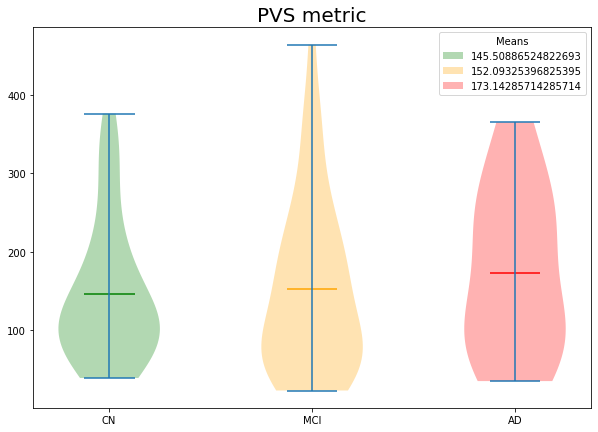

In [105]:
# step 6: plot stuff

#try: https://stackoverflow.com/questions/67376683/can-you-have-a-box-plot-overlap-a-half-violin-plot-on-a-raincloud-plot-using-pyt
#try: https://github.com/pog87/PtitPrince


## combine these different collections into a list
data_to_plot = [cn_txfm, mci_txfm, ad_txfm]

# Create a figure instance
fig = plt.figure(figsize=(10,7))

# Create the boxplot
violin = plt.violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)

# Set the color of the violin patches
colors = ['Green', 'Orange', 'Red']
for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
violin['cmeans'].set_colors(colors)
plt.xticks([1, 2, 3], labels=['CN', 'MCI', 'AD'])
plt.legend([np.mean(cn_txfm), np.mean(mci_txfm), np.mean(ad_txfm)],title='Means')
#plt.ylim(cn_txfm.max()*-1.3,cn_txfm.max()*1.3)
plt.title('PVS metric',fontsize=20)

# y, h, col = max(map(max, data_to_plot)) + 2, 2, 'k'
# plt.text(,y+h, "*", ha='center', va='bottom', color=col)

plt.show()

In [28]:
# stats comparison giant table
# need to compute: 
    # non transformed & transformed for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # shapiro-wilks test for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # ANOVA, ttest, kruskal wallis, mann whitney u for: cn vs ad, cn vs mci, mci vs ad for each condition above
    # means and std


    
    

In [29]:
# step n: regional stats (need to come up with a pipeline for this, not straight forward)
# should get: HP, GM / BG, CSO

## Extract Stats -- Longitudinal

In [49]:
# # step 1: how many time points do we want?
# # how many time points do each participant have?

report_clean.groupby('SubjectCodes').count().groupby('subjects').count() # 454 w 1tp, 257 w 2tp, 186 w 3tp
#report_clean.groupby('SubjectCodes').count()
counts = report_clean.groupby('SubjectCodes').count()
counts
yr3_group = report_clean.iloc[np.where(counts['subjects'] == 3)]

#yr3_group
#rggroupyr3 = yr3_group.groupby(['research group'])

# ad_lg = rggroupyr3.get_group('AD')
# mci_lg = rggroupyr3.get_group('MCI')
# cn_lg = rggroupyr3.get_group('CN')

# ad_lg


,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
1,ADNI3_114_S_4404y00_i949873,AD,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,0
2,ADNI3_128_S_4742y00_i1039209,MCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,0
6,ADNI3_128_S_2130y02_i1504435,MCI,ADNI3_128_S_2130y02,128_S_2130,i1504435,y02,87.4,72.6,M,3154.0,11889.0,0.007082,2571.0,7619.0,0.004538,no,yes,2
9,ADNI3_126_S_4891y04_i1605998,MCI,ADNI3_126_S_4891y04,126_S_4891,i1605998,y04,69.7,86.0,M,2269.0,10461.0,0.006958,1593.0,6982.0,0.004644,no,yes,4
10,ADNI3_024_S_4674y02_i1179769,MCI,ADNI3_024_S_4674y02,024_S_4674,i1179769,y02,85.1,92.1,M,2960.0,11558.0,0.007413,2237.0,7165.0,0.004596,no,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,ADNI3_082_S_6629y02_i1516245,CN,ADNI3_082_S_6629y02,082_S_6629,i1516245,y02,60.2,72.6,F,1002.0,4264.0,0.003306,349.0,985.0,0.000764,no,yes,2
1030,ADNI3_002_S_6404y00_i1021530,CN,ADNI3_002_S_6404y00,002_S_6404,i1021530,y00,66.1,69.9,M,1175.0,5649.0,0.003761,592.0,2073.0,0.001380,no,yes,0
1034,ADNI3_035_S_6722y00_i1159023,CN,ADNI3_035_S_6722y00,035_S_6722,i1159023,y00,80.8,74.8,F,1304.0,4369.0,0.003236,648.0,1299.0,0.000962,no,yes,0
1035,ADNI3_070_S_5040y00_i992757,CN,ADNI3_070_S_5040y00,070_S_5040,i992757,y00,81.4,77.1,F,3018.0,9667.0,0.007227,2295.0,6005.0,0.004489,no,yes,0
